In [70]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [71]:
def extract_answer(text):
    try:
        text_processed = text.split('"answer":')[-1].split('\n')[0].strip().split('"')[1].strip()
    except:
        text_processed = text.split('"answer":')[-1].split('\n')[0].strip()
    return text_processed


In [78]:
PROMPT_RESPONSE_PATH = "../../../data/analysis_results/Llama_2_13b_chat_hf_prompt_based_two_hop_mcq_disease_gene_response.csv"

RAG_RESPONSE_PATH = "../../../data/analysis_results/Llama_2_13b_chat_hf_node_retrieval_rag_based_two_hop_mcq_disease_gene_response.csv"


In [79]:
prompt_response_df = pd.read_csv(PROMPT_RESPONSE_PATH)
rag_response_df = pd.read_csv(RAG_RESPONSE_PATH)

prompt_response_df.loc[:, 'extracted_answer'] = prompt_response_df['llm_answer'].apply(extract_answer)
rag_response_df.loc[:, 'extracted_answer'] = rag_response_df['llm_answer'].apply(extract_answer)


In [80]:
def evaluate(df):
    correct = df[df.correct_answer == df.extracted_answer]
    incorrect = df[df.correct_answer != df.extracted_answer]
    correct_frac = correct.shape[0]/df.shape[0]
    incorrect_frac = incorrect.shape[0]/df.shape[0]
    return correct_frac, incorrect_frac

niter = 100
nsample = 30

prompt_correct_frac_list = []
rag_correct_frac_list = []
for _ in tqdm(range(niter)):
    prompt_response_df_sample = prompt_response_df.sample(n=nsample)
    prompt_correct_frac, prompt_incorrect_frac = evaluate(prompt_response_df_sample)

    rag_response_df_sample = rag_response_df.iloc[prompt_response_df_sample.index]
    rag_correct_frac, rag_incorrect_frac = evaluate(rag_response_df_sample)

    prompt_correct_frac_list.append(prompt_correct_frac)
    rag_correct_frac_list.append(rag_correct_frac)


100%|███████████████████████████████████████| 100/100 [00:00<00:00, 1141.29it/s]


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_42779/633951590.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_42779/633951590.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)


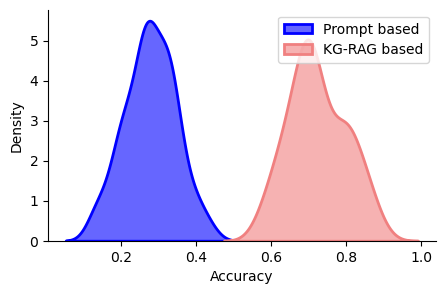

In [82]:

# Create a figure and axis
fig = plt.figure(figsize=(5, 3))
ax = plt.gca()

# Plot KDEs with the specified styling
sns.kdeplot(prompt_correct_frac_list, color="blue", shade=True, label="Prompt based", ax=ax, lw=2, linestyle="-", alpha=0.6)
sns.kdeplot(rag_correct_frac_list, color="lightcoral", shade=True, label="KG-RAG based", ax=ax, lw=2, linestyle="-", alpha=0.6)

# Set the outline color to black
for artist in ax.lines:
    artist.set_edgecolor("black")

# Add labels and legend
plt.xlabel("Accuracy")
plt.ylabel("Density")
plt.legend()

sns.despine(top=True, right=True)

# Show the plot
plt.show()

fig_filename = "../../../data/analysis_results/figures/two_hop_DISEASE_GENE_mcq_llm_performance.svg"

fig.savefig(fig_filename, format='svg', bbox_inches='tight')


In [88]:
np.std(rag_correct_frac_list)

0.07666666666666669

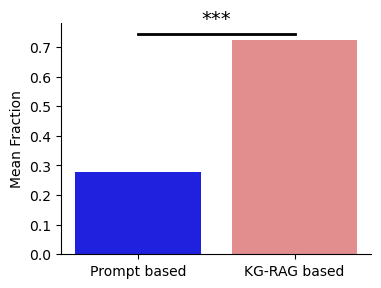

In [83]:


# Perform a t-test
t_stat, p_value = stats.ttest_ind(prompt_correct_frac_list, rag_correct_frac_list)

# Create a figure and axis
plt.figure(figsize=(4, 3))
ax = plt.gca()

# Create bar plot with error bars
sns.barplot(x=["Prompt based", "KG-RAG based"], y=[np.mean(prompt_correct_frac_list), np.mean(rag_correct_frac_list)], errorbar="sd", palette=["blue", "lightcoral"], ax=ax)

# Calculate the height for the text and line
height = max(np.mean(prompt_correct_frac_list), np.mean(rag_correct_frac_list)) + 0.02

# Add a horizontal line between the two bars
ax.plot([0, 1], [height, height], c="black", lw=2)

# Add text annotation for significance
if p_value > 0.05:
    annotation = "ns"
elif 0.001 < p_value <= 0.05:
    annotation = "*"
else:
    annotation = "***"

# Add the annotation text above the line
plt.text(0.5, height + 0.02, annotation, ha='center', va='bottom', fontsize=14)

# Add labels
plt.ylabel("Mean Fraction")

sns.despine(top=True, right=True)

# Show the plot
plt.show()


In [84]:
p_value

3.247798196995595e-103

In [69]:
len(prompt_correct_frac_list)

100